In [2]:
import functools

import diffrax
import equinox
import jax
import optax
import scipy.stats

jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")
import jax.numpy as jnp
import numpy as np
from matplotlib.figure import Figure
from tqdm.notebook import trange

%matplotlib inline

# Simulate stochastic Lorenz system

In [3]:
@equinox.filter_jit
def F_true(x, key, σ=2, T=0.05, dt=1e-2, tol=None):
    # Lorenz parameters
    sigma = 10.0
    rho = 28.0
    beta = 8 / 3

    # Drift function f(t, y)
    def drift(t, y, _args):
        x, y_, z = y
        dx = sigma * (y_ - x)
        dy = x * (rho - z) - y_
        dz = x * y_ - beta * z
        return jnp.array([dx, dy, dz])

    # Diffusion function g(t, y)
    def diffusion(t, y, _args):
        return jnp.eye(3) * σ

    # SDE solver
    solver = diffrax.ShARK()

    # Solve
    bm = diffrax.VirtualBrownianTree(
        t0=0,
        t1=T,
        tol=(tol or dt / 2),
        shape=(3,),
        key=key,
        levy_area=diffrax.SpaceTimeLevyArea,
    )
    # Set up the SDE
    sde = diffrax.MultiTerm(diffrax.ODETerm(drift), diffrax.ControlTerm(diffusion, bm))
    # Solve the SDE
    sol = diffrax.diffeqsolve(
        sde,
        solver=solver,
        t0=0,
        t1=T,
        dt0=dt,
        y0=x,
        max_steps=10000,
    )
    return sol.ys

In [4]:
# analytic beats E and U at 0.4.
# they're all the same around 0.2
lorenz_args = dict(σ=2.0, T=0.3, dt=1e-2)

In [5]:
F_true_train_and_test = jax.jit(jax.vmap(functools.partial(F_true, **lorenz_args)))

In [7]:
N = 10000

keys = jax.random.split(jax.random.PRNGKey(3), (N, 2))
x_train_and_test = np.zeros((N, 2, 3))
x_train_and_test[0, :, :] = [-8.0, 4.0, 27.0]
for i in trange(1, N):
    x_train_and_test[i, :, :] = F_true_train_and_test(
        x_train_and_test[i - 1, :], keys[i - 1, :]
    ).squeeze()

  0%|          | 0/9999 [00:00<?, ?it/s]

In [8]:
x_train = x_train_and_test[:, 0, :]
x_test = x_train_and_test[:, 1, :]

Preview train and test trajectories (which start from the same initial conditions but have independent process noise)

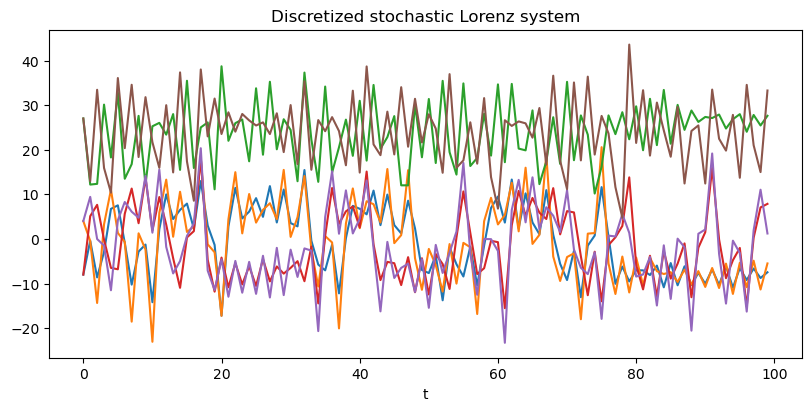

In [17]:
fig = Figure(figsize=(8, 4), dpi=100, constrained_layout=1)
ax = fig.gca()
ax.plot(x_train[:100])
ax.plot(x_test[:100])
ax.set_title("Discretized stochastic Lorenz system")
ax.set_xlabel("t")
fig

# Learn a deep neural approximation to F

In [10]:
import os
import sys

import equinox

lib_path = os.path.join(os.path.curdir, "src")
sys.path.insert(0, lib_path)
import importlib

import probit_network
import random_matrix
import unscented

importlib.reload(unscented)
importlib.reload(random_matrix)
importlib.reload(probit_network)
from probit_network import ProbitLinear, ProbitLinearNetwork
from random_matrix import RandomGaussian, RandomOrthogonalProjection, ZeroMatrix

Network architecure with two hidden layers of 100 neurons each

In [11]:
n_x = 3
n_hidden = 100
# TODO why does calling this network break on GPU
network = ProbitLinearNetwork(
    ProbitLinear.create_probit(
        in_size=n_x,
        out_size=n_hidden,
        key=jax.random.PRNGKey(1),
        A=RandomOrthogonalProjection(),
        b=RandomOrthogonalProjection(),
    ),
    ProbitLinear.create_residual(
        in_size=n_hidden,
        out_size=n_hidden,
        key=jax.random.PRNGKey(2),
        A=RandomOrthogonalProjection(),
        b=RandomOrthogonalProjection(),
    ),
    ProbitLinear.create_residual(
        in_size=n_hidden,
        out_size=n_hidden,
        key=jax.random.PRNGKey(3),
        A=RandomOrthogonalProjection(),
        b=RandomOrthogonalProjection(),
    ),
    ProbitLinear.create_linear(
        in_size=n_hidden,
        out_size=n_x,
        C=RandomOrthogonalProjection(),
        d=RandomOrthogonalProjection(),
    ),
)

Least-squares loss

In [12]:
@jax.jit
def get_loss(model, x_time_series):
    pred_x = jax.vmap(model)(x_time_series[:-1])
    actual_x = x_time_series[1:]
    return jnp.mean((pred_x - actual_x) ** 2)


loss_value_and_grad = equinox.filter_value_and_grad(get_loss)

AdamW optimizer with lightly hand-tuned training hyperparameters

In [13]:
opt = optax.adamw(learning_rate=1e-3, b1=0.9, b2=0.99)

opt_state = opt.init(network)


@equinox.filter_jit
def step(model, x, opt_state):
    loss, grads = loss_value_and_grad(model, x)
    updates, opt_state = opt.update(grads, opt_state, params=model)
    model = equinox.apply_updates(model, updates)
    return loss, model, opt_state

In [14]:
loss_history = []

In [16]:
pbar = trange(1000)
# optional GPU acceleration (not much faster but relieves CPU workload)
with jax.default_device(jax.devices("cpu")[0]):
    for i in pbar:
        loss, network, opt_state = step(network, x_train, opt_state)
        test_loss = get_loss(network, x_test)
        loss_history.append((loss, test_loss))
        if i % 10 == 0:
            train_rmse = loss.item() ** 0.5
            test_rmse = test_loss.item() ** 0.5
            pbar.set_postfix({"rmse": f"{train_rmse:.6f}, {test_rmse:.6f}"})

  0%|          | 0/1000 [00:00<?, ?it/s]

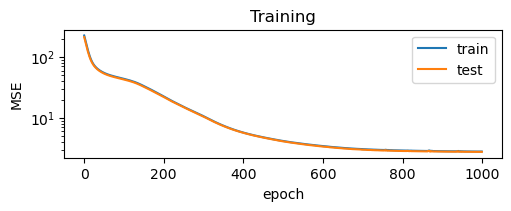

In [18]:
fig = Figure(figsize=(5, 2), constrained_layout=1)
ax = fig.gca()
ax.plot(loss_history, label=["train", "test"])
ax.legend()
ax.set_title("Training")
ax.set_ylabel("MSE")
ax.set_xlabel("epoch")
ax.set_yscale("log")
fig

Estimate process covariance using prediction residuals

In [19]:
residual = jax.vmap(network)(x_test[:-1]) - x_test[1:]
Q_0 = jax.vmap(jnp.outer)(residual, residual).mean(axis=0)
print("Q eigenvalues", np.linalg.eigvalsh(Q_0))

Q eigenvalues [0.36801204 3.18041379 4.78966073]


Predict a sample trajectory

In [20]:
x_pred = np.zeros((N, 3))
x_pred[0] = x_test[0]
for i in trange(1, N):
    x_pred[i, :] = network(x_pred[i - 1, :])

  0%|          | 0/9999 [00:00<?, ?it/s]

Vibe check: preview the tail of the trajectory (the end is more sensitive to degeneracy than the beginning)

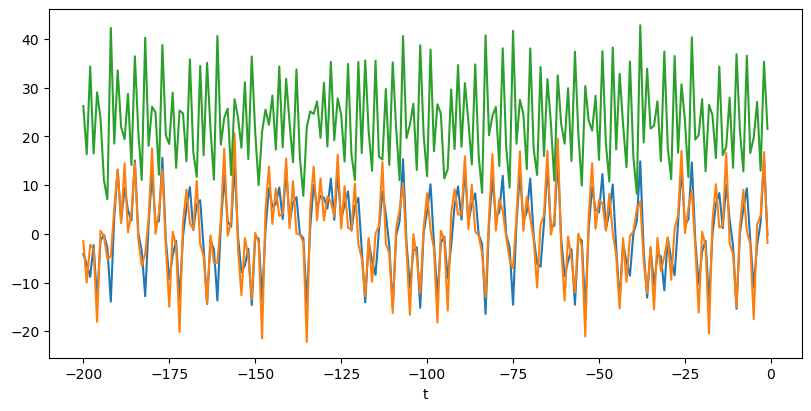

In [22]:
fig = Figure(figsize=(8, 4), dpi=100, constrained_layout=1)
ax = fig.gca()
ax.plot(np.arange(-200, 0), x_pred[-200:])
ax.set_xlabel("t")
fig

# UQ: propagate $\mathcal N(x_0, Q)$ through $\hat F$

In [23]:
μ_in = x_train[0]
Σ_in = Q_0

In [24]:
input_samples = scipy.stats.qmc.MultivariateNormalQMC(
    mean=μ_in, cov=Σ_in, rng=10
).random(2**14)

output_samples = jax.vmap(network)(input_samples)

In [25]:
μ_unscented, Σ_unscented = network.propagate_mean_cov(μ_in, Σ_in, method="unscented")
μ_linear, Σ_linear = network.propagate_mean_cov(μ_in, Σ_in, method="linear")
μ_analytic, Σ_analytic = network.propagate_mean_cov(μ_in, Σ_in, method="analytic")

In [26]:
μ_monte_carlo = np.mean(output_samples, axis=0)
Σ_monte_carlo = np.cov(output_samples, rowvar=False, ddof=1)

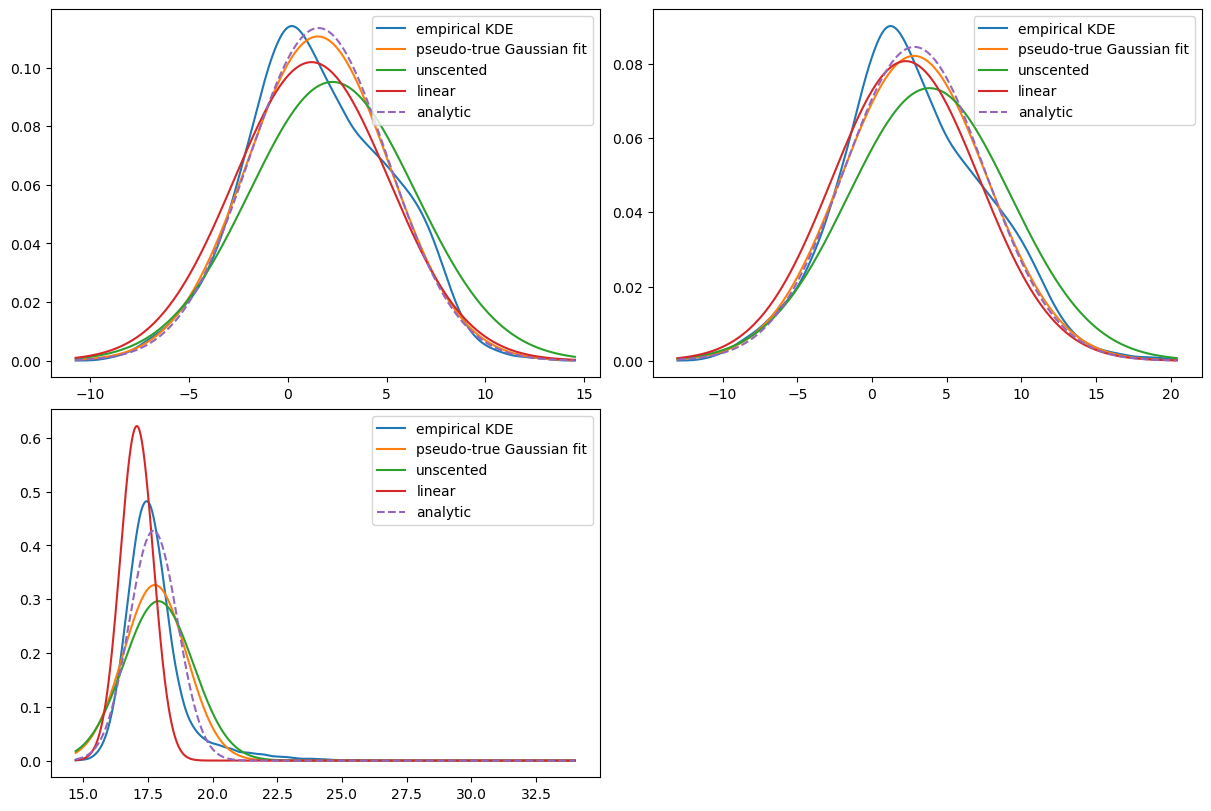

In [27]:
fig = Figure(figsize=(12, 8), dpi=100, constrained_layout=1)
for i in range(3):
    ax = fig.add_subplot(2, 2, i + 1)
    grid = np.linspace(np.min(output_samples[:, i]), np.max(output_samples[:, i]), 2000)
    ax.plot(
        grid,
        scipy.stats.gaussian_kde(output_samples[:, i].reshape(-1))(grid),
        label="empirical KDE",
    )
    for label, μ, Σ, linestyle in (
        ("pseudo-true Gaussian fit", μ_monte_carlo, Σ_monte_carlo, "-"),
        ("unscented", μ_unscented, Σ_unscented, "-"),
        ("linear", μ_linear, Σ_linear, "-"),
        ("analytic", μ_analytic, Σ_analytic, "--"),
    ):
        ax.plot(
            grid,
            scipy.stats.norm.pdf(grid, loc=μ[i], scale=Σ[i, i] ** 0.5),
            label=label,
            linestyle=linestyle,
        )
    ax.legend()

fig

# Kalman filter example
## Generate data

In [28]:
from probit_network import rectify_eigenvalues

In [29]:
@equinox.filter_jit
def schur_complement(A, B, C, x, y, method=1):
    """Returns a numerically stable(ish) attempt at
    x + B C^(-1) y,
    A - B C^(-1) B^T.
    """
    if method == 1:
        # C = U U^T
        U = jax.scipy.linalg.cholesky(C)
        # B_tilde = B U^-T
        B_tilde = jax.scipy.linalg.solve_triangular(U, B.T, trans=1, lower=False).T
        return (
            x + B_tilde @ jax.scipy.linalg.solve_triangular(U, y, lower=False),
            (A - B_tilde.dot(B_tilde.T)),
        )

In [30]:
n_x = 3
n_u = 0
n_y = 1

F = network
H = ProbitLinearNetwork(
    ProbitLinear.create_linear(
        in_size=n_x + n_u,
        out_size=n_y,
        C=np.eye(n_x)[(0,), :],
        d=np.zeros((n_y)),
    )
)
H_aug = H.augment_with_identity()

In [31]:
sim_horizon = 2000
R = jnp.eye(n_y) * 1e-2

In [32]:
process_noise_keys = jax.random.split(jax.random.PRNGKey(122), sim_horizon)

In [33]:
with jax.default_device(jax.devices("cpu")[0]):
    ϵ = jax.random.multivariate_normal(
        mean=jnp.zeros(n_y), cov=R, key=jax.random.PRNGKey(300), shape=sim_horizon
    )

In [34]:
x = np.ones((sim_horizon, n_x))
x[0] = [-8.0, 4.0, 27.0]
y = np.zeros((sim_horizon, n_y))
y_noiseless = np.zeros((sim_horizon, n_y))
for i in trange(1, sim_horizon):
    x[i, :] = F_true(x[i - 1, :], process_noise_keys[i - 1], **lorenz_args)
    y_noiseless[i, :] = H(x[i, :])
    y[i, :] = y_noiseless[i, :] + ϵ[i]

  0%|          | 0/1999 [00:00<?, ?it/s]

Actual state and output trajectory

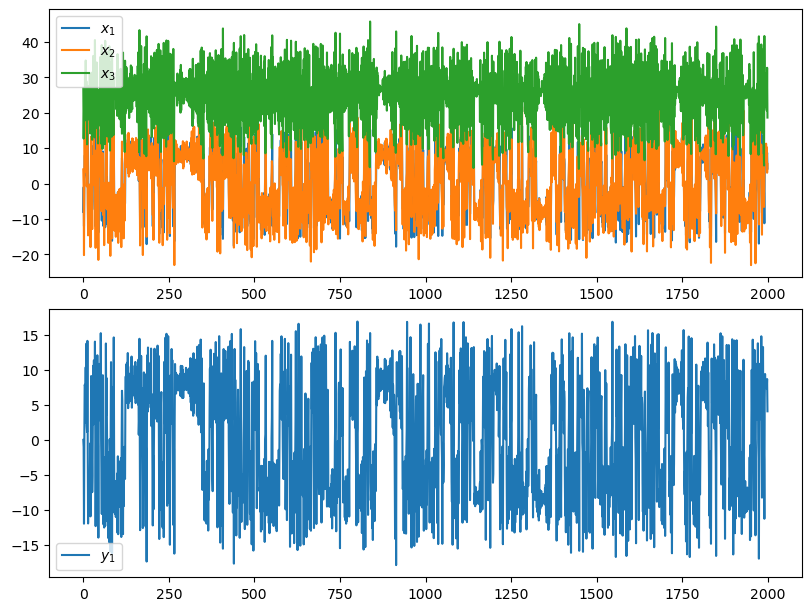

In [35]:
fig = Figure(figsize=(8, 6), dpi=100, constrained_layout=1)
ax = fig.add_subplot(211)
for i in range(n_x):
    ax.plot(x[:, i], label=rf"$x_{i+1}$")
ax.legend()
ax = fig.add_subplot(212)
for i in range(n_y):
    ax.plot(y[:, i], label=rf"$y_{i+1}$")
ax.legend()
fig

## Filtering

In [36]:
import neural_kalman

importlib.reload(neural_kalman)
import kalman_diagnostics

importlib.reload(kalman_diagnostics)

<module 'kalman_diagnostics' from '/home/simon/Documents/School/Research/neural-network-kalman/src/kalman_diagnostics.py'>

In [64]:
method = "analytic"
# method = "linear"
# method = "unscented"

recalibrate = False

In [65]:
Q = Q_0
kalman = neural_kalman.NeuralKalmanFilter(n_x=n_x, n_u=n_u, n_y=n_y, F=F, H=H, Q=Q, R=R)

In [66]:
joint_prediction = np.zeros((sim_horizon, n_x + n_u + n_y))
x_post = np.zeros((sim_horizon, n_x))
P_pred = np.zeros((sim_horizon, n_x + n_u + n_y, n_x + n_u + n_y))
P_post = np.zeros((sim_horizon, n_x, n_x))

joint_prediction[0, kalman.STATES] = x_post[0, kalman.STATES] = x[0]
P_pred[0, kalman.STATES, kalman.STATES] = Q
P_post[0, kalman.STATES, kalman.STATES] = Q

In [67]:
for i in trange(1, sim_horizon):
    # predict (x, y)[i | i - 1] using x[i - 1| i - 1]
    joint_prediction[i, kalman.JOINT], P_pred[i, kalman.JOINT, kalman.JOINT] = (
        kalman.predict(x_post[i - 1], P_post[i - 1], method=method)
    )
    # correct x[i | i - 1] to x[i | i]
    x_post[i, kalman.STATES], P_post[i, kalman.STATES, kalman.STATES] = kalman.correct(
        joint_prediction[i, kalman.JOINT],
        P_pred[i, kalman.JOINT, kalman.JOINT],
        y[i],
        recalibrate=recalibrate,
        recalibrate_method=method,
    )

  0%|          | 0/1999 [00:00<?, ?it/s]

In [68]:
x_smoothed = x_post.copy()
P_smoothed = P_post.copy()

for i in trange(sim_horizon - 2, 0 - 1, -1):
    x_smoothed[i], P_smoothed[i] = kalman.smooth(
        x_smoothed[i],
        P_smoothed[i],
        x_smoothed[i + 1],
        P_smoothed[i + 1],
        method=method,
    )

  0%|          | 0/1999 [00:00<?, ?it/s]

In [69]:
x_pred =joint_prediction[:, kalman.STATES]
print("rms(predicted x - true x)", ((x - x_pred) ** 2).mean() ** 0.5)
print("rms(post x - true x)", ((x - x_post) ** 2).mean() ** 0.5)
print("rms(smoothed x - true x)", ((x - x_smoothed) ** 2).mean() ** 0.5)

rms(predicted x - true x) 2.5738096493349274
rms(post x - true x) 1.322736670063482
rms(smoothed x - true x) 1.0402539213091937


In [70]:
time_slice = slice(sim_horizon // 2 - 50, sim_horizon // 2 + 50)

In [71]:
diagnostics = kalman_diagnostics.KalmanDiagnostics(kalman_filter=kalman, x=x)

Plot the actual states under the 90% prediction interval. Expect 10 misses in this time segment.

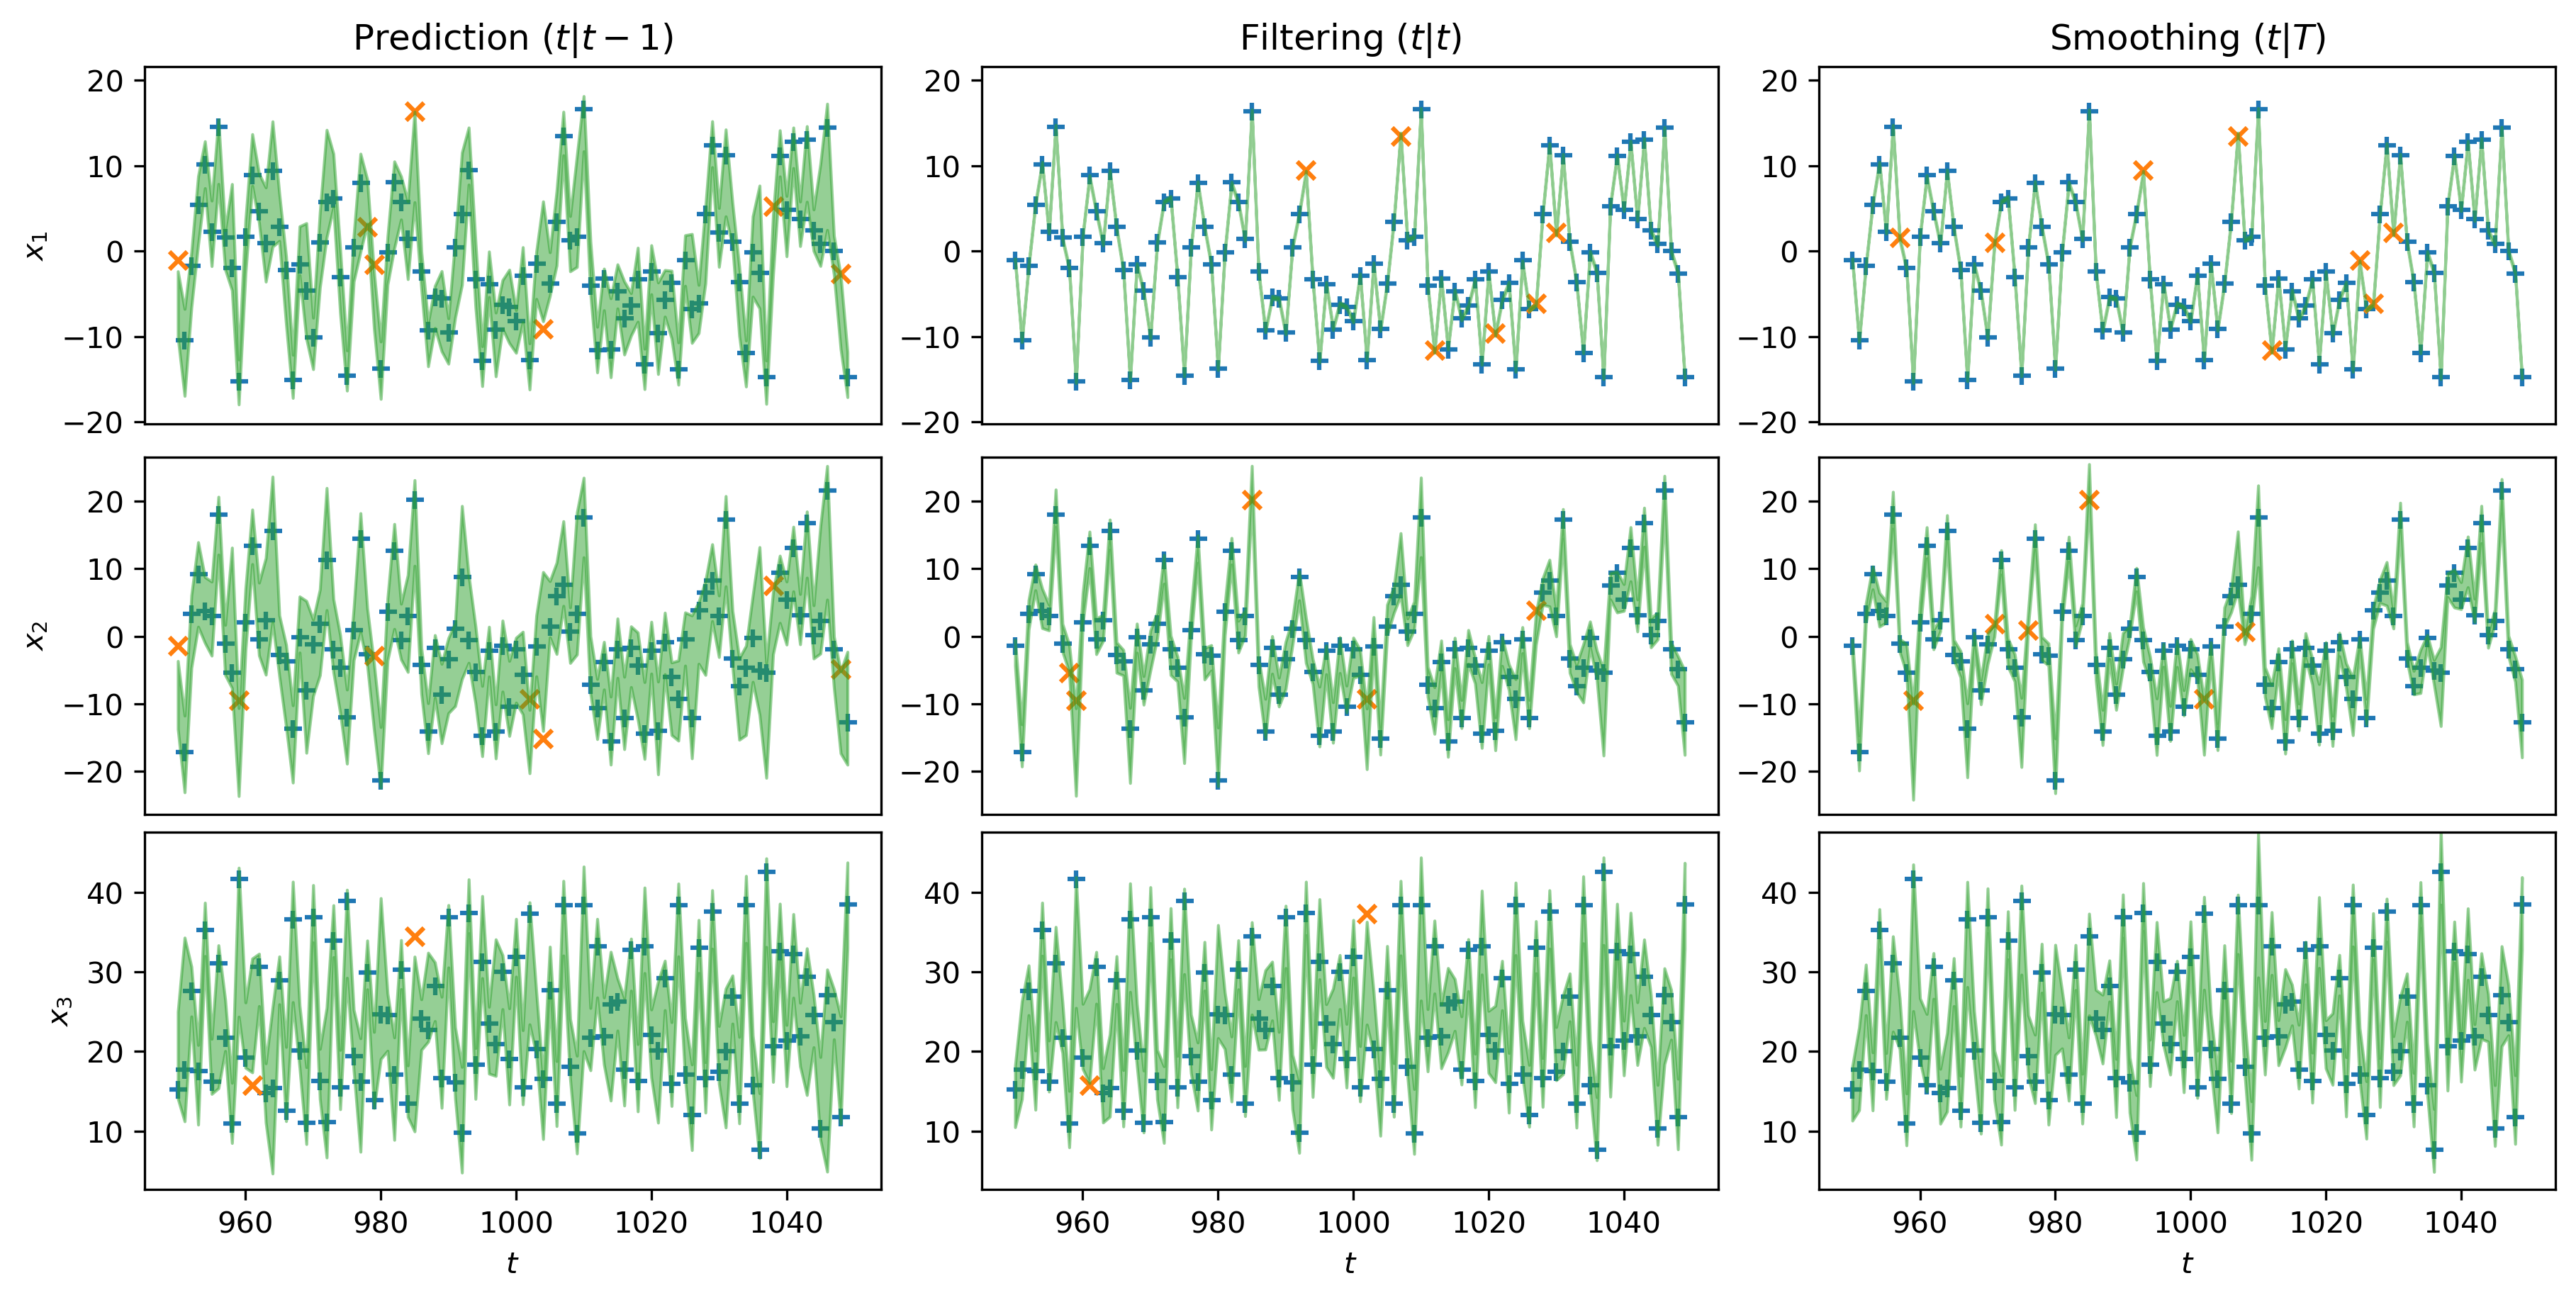

In [72]:
fig = Figure(figsize=(12, 6), dpi=300, constrained_layout=1)
for i in range(n_x):
    for j, (state_trajectory, cov_trajectory, desc) in enumerate(
        [
            (x_pred, P_pred, "Prediction $(t|t-1)$"),
            (x_post, P_post, "Filtering $(t|t)$"),
            (x_smoothed, P_smoothed, "Smoothing $(t|T)$"),
        ]
    ):
        # prepare and decorate axes
        ax = fig.add_subplot(3, 3, 3 * i + j + 1)
        if j == 0:
            ax.set_ylabel(rf"$x_{i+1}$")
        else:
            pass  # ax.set_yticks([])
        if i == 0:
            ax.set_title(desc)
        if i == 2:
            ax.set_xlabel(rf"$t$")
        else:
            ax.set_xticks([])
        # get data to plot
        times, state, _mean, lower, upper, covered, missed = (
            diagnostics.plot_state_trajectories(
                state_trajectory, cov_trajectory, i, time_slice, coverage=0.9
            )
        )
        # plot data
        ax.set_ylim(min(state) - 5, max(state) + 5)
        ax.scatter(
            times[covered],
            state[covered],
            color="C0",
            marker="+",
        )
        ax.scatter(
            times[missed],
            state[missed],
            color="C1",
            marker="x",
        )
        ax.fill_between(
            times,
            lower,
            upper,
            color="C2",
            alpha=0.5,
        )
fig

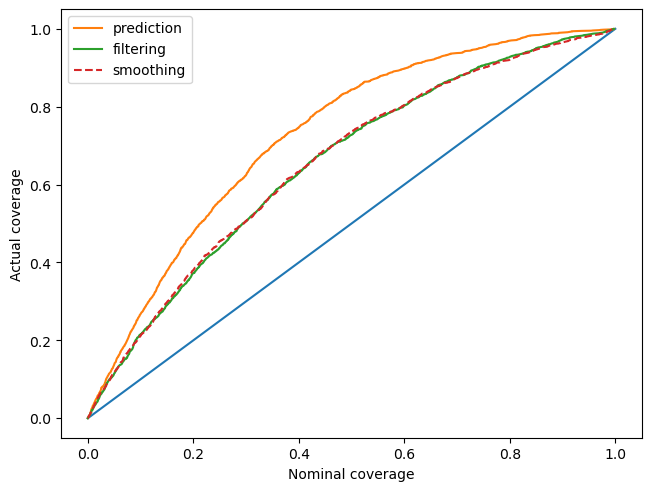

In [54]:
fig = Figure(dpi=100, constrained_layout=1)
ax = fig.add_subplot()
ax.plot([0, 1], [0, 1])
ax.plot(*diagnostics.calculate_coverage(x_pred, P_pred), label="prediction")
ax.plot(*diagnostics.calculate_coverage(x_post, P_post), label="filtering")
ax.plot(
    *diagnostics.calculate_coverage(x_smoothed, P_smoothed),
    label="smoothing",
    linestyle="--"
)
ax.set_xlabel("Nominal coverage")
ax.set_ylabel("Actual coverage")
ax.legend()
# fig.savefig(f"/tmp/coverage-{method}.jpg")
# fig.savefig(f"figures/kalman/coverage-{method}.pdf")
fig

# Performance analysis: I/Os and flops
## predict

In [55]:
print(f"{'Method':<10} {'I/Os':>10} {'FLOPs':>10}")
for method in ["analytic", "linear", "unscented"]:
    cost_analysis = (
        jax.jit(functools.partial(kalman.predict, method=method))
        .trace(x_post[0], P_post[0])
        .lower()
        .compile()
        .cost_analysis()
    )

    print(
        f"{method:<10} {cost_analysis['bytes accessed']:>10} {cost_analysis['flops']:>10}"
    )

Method           I/Os      FLOPs
analytic   27112288.0 41924200.0
linear      5864083.0 27094464.0
unscented    469628.0   784107.0


## update

In [56]:
print(f"{'Method':<10} {"Recalibrate":<10} {'I/Os':>10} {'FLOPs':>10}")
for recalibrate in [True, False]:
    for method in ["analytic", "linear", "unscented"] if recalibrate else ["all"]:
        cost_analysis = (
            jax.jit(
                functools.partial(
                    kalman.correct, recalibrate_method=method, recalibrate=recalibrate
                )
            )
            .trace(
                joint_prediction[i, kalman.JOINT],
                P_pred[i, kalman.JOINT, kalman.JOINT],
                y[i],
            )
            .lower()
            .compile()
            .cost_analysis()
        )
        print(
            f"{method:<10} {str(recalibrate):<10} {cost_analysis['bytes accessed']:>10} {cost_analysis['flops']:>10}"
        )

Method     Recalibrate       I/Os      FLOPs
analytic   True          16152.0     6008.0
linear     True           4464.0     1288.0
unscented  True           9571.0     4839.0
all        False           369.0       24.0


## smooth

In [57]:
print(f"{'Method':<10} {'I/Os':>10} {'FLOPs':>10}")
for method in ["analytic", "linear", "unscented"]:
    cost_analysis = (
        jax.jit(functools.partial(kalman.smooth, method=method))
        .trace(x_smoothed[0], P_smoothed[0], x_smoothed[1], P_smoothed[1])
        .lower()
        .compile()
        .cost_analysis()
    )
    print(
        f"{method:<10} {cost_analysis['bytes accessed']:>10} {cost_analysis['flops']:>10}"
    )

Method           I/Os      FLOPs
analytic   28798876.0 45643288.0
linear      6249342.0 29652908.0
unscented    498388.0   833034.0
